In [372]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv('/Users/baptistecarbillet/Documents/MachineLearning3/MachineLearning1/smoking_driking_dataset_Ver01.csv')
dfTrue = pd.read_csv('/Users/baptistecarbillet/Documents/MachineLearning3/MachineLearning1/smoking_driking_dataset_Ver01.csv')
df.drop('DRK_YN', axis=1, inplace=True)
#Male get one hot encoding
df['sex'] = df['sex'].apply(lambda x: 1 if x == 'Male' else 0)

#Normalise df
#normalization
dfMean = df.iloc[:,:-1].mean()
dfStd = df.iloc[:,:-1].std()
df.iloc[:,:-1]=  (df.iloc[:,:-1] - dfMean) / (dfStd)

random_state = 75
df_1 = df[df['SMK_stat_type_cd'] == 1.0].sample(5000,random_state=random_state)
df_2 = df[df['SMK_stat_type_cd'] == 2.0].sample(5000,random_state=random_state)
df_3 = df[df['SMK_stat_type_cd'] == 3.0].sample(5000,random_state=random_state)

X_1,y_1 = np.array(df_1.drop('SMK_stat_type_cd',axis=1)),np.array(df_1['SMK_stat_type_cd'])
X_2,y_2 = np.array(df_2.drop('SMK_stat_type_cd',axis=1)),np.array(df_2['SMK_stat_type_cd'])
X_3,y_3 = np.array(df_3.drop('SMK_stat_type_cd',axis=1)),np.array(df_3['SMK_stat_type_cd'])

from sklearn.model_selection import train_test_split

random_state = 75 #Paris

X_train_1,X_test_1,y_train_1,y_test_1 = train_test_split(X_1,y_1,test_size=0.2,random_state=random_state)
X_train_2,X_test_2,y_train_2,y_test_2 = train_test_split(X_2,y_2,test_size=0.2,random_state=random_state)
X_train_3,X_test_3,y_train_3,y_test_3 = train_test_split(X_3,y_3,test_size=0.2,random_state=random_state)

X_train = np.concatenate((X_train_1,X_train_2,X_train_3))
y_train = np.concatenate((y_train_1,y_train_2,y_train_3))

X_test = np.concatenate((X_test_1,X_test_2,X_test_3))
y_test = np.concatenate((y_test_1,y_test_2,y_test_3))

In [219]:
dfTrue.hear_left.quantile([0.25,0.5,0.75])

0.25    1.0
0.50    1.0
0.75    1.0
Name: hear_left, dtype: float64

## EM algorithm

In [2]:
X_train.shape

(12000, 22)

In [149]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
sil_list = []
for i in range(2,23):
    gmm = GaussianMixture(n_components=i,random_state=random_state)
    gmm.fit(X_train)
    sil_list.append(silhouette_score(X_train,gmm.predict(X_train)))

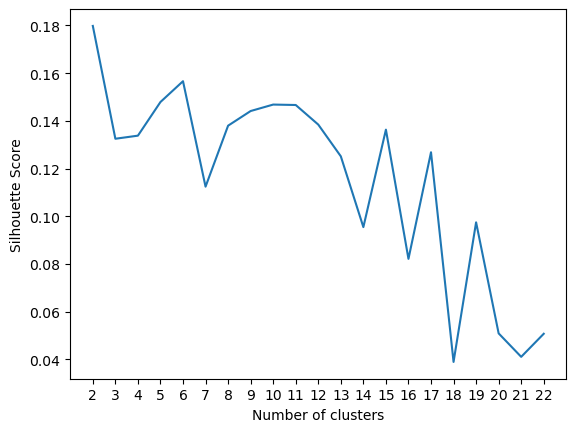

In [153]:
plt.plot(range(2,23),sil_list)
plt.xticks(range(2,23))
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()

In [373]:
from sklearn.metrics import confusion_matrix
gmm = GaussianMixture(n_components=2,random_state=random_state)
gmm.fit(X_train)

GaussianMixture(n_components=2, random_state=75)

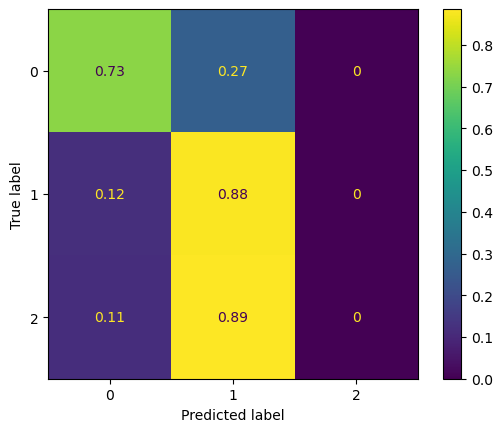

In [375]:
from sklearn.metrics import confusion_matrix

from sklearn.metrics import ConfusionMatrixDisplay
cm = confusion_matrix(y_train - 1,gmm.predict(X_train),normalize='true')
disp_gmm_lab = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['0','1','2'])

disp.plot()


In [376]:
# confusion matrix between sex and cluster prediction

cm = confusion_matrix(X_train[:,0] > 0,gmm.predict(X_train),normalize='true')
cm

array([[1.        , 0.        ],
       [0.04563585, 0.95436415]])

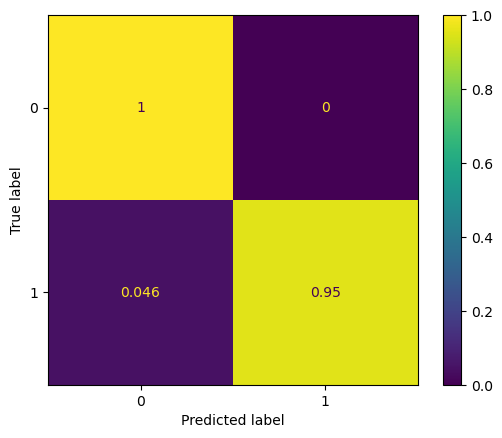

In [378]:
disp_gmm_sex = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['0','1'])
disp_gmm_sex.plot()

cluster analysis em:

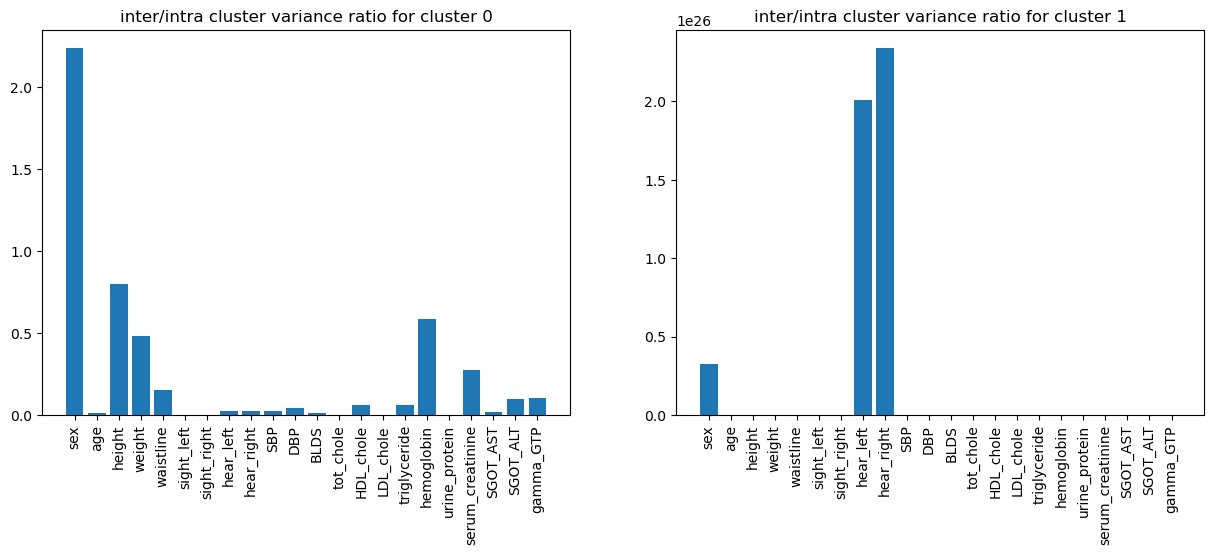

In [158]:
#get intra cluster variance for each features
intra_cluster_variance_em = []
for i in range(2):
    intra_cluster_variance_em.append(np.var(X_train[gmm.predict(X_train) == i],axis=0))
    
#get inter cluster variance for each features
inter_cluster_variance_em = np.var(gmm.means_,axis=0)

#compute the ratio
ratio = inter_cluster_variance_em/intra_cluster_variance_em
fig, ax = plt.subplots(1,2,figsize=(15,5))
ax[0].bar(range(22),ratio[0],label='cluster 0')
ax[1].bar(range(22),ratio[1],label='cluster 1')
ax[0].set_xticks(range(22),df.columns[:-1],rotation=90)
ax[1].set_xticks(range(22),df.columns[:-1],rotation=90)
ax[0].set_title('inter/intra cluster variance ratio for cluster 0')
ax[1].set_title('inter/intra cluster variance ratio for cluster 1')

plt.show()

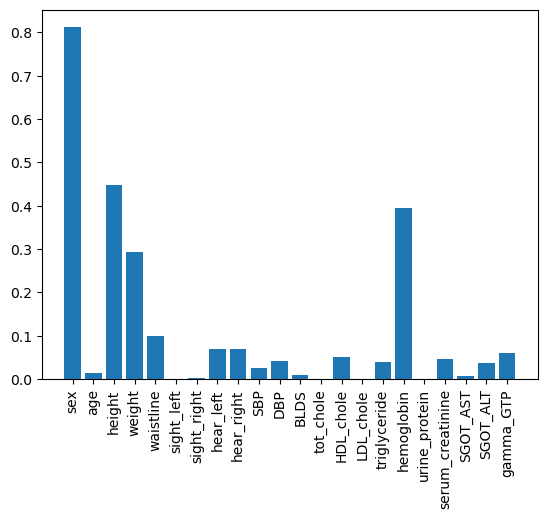

In [159]:
plt.bar(range(22),inter_cluster_variance_em)
plt.xticks(range(22),df.columns[:-1],rotation=90)
plt.show()

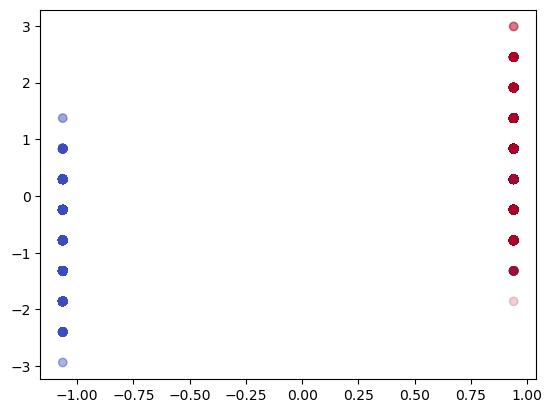

In [165]:
#scatter plot
col1 = 'sex'
col2 = 'height'

indcol1 = df.columns.get_loc(col1)
indcol2 = df.columns.get_loc(col2)

plt.scatter(X_train[:,indcol1],X_train[:,indcol2],c=gmm.predict(X_train),cmap='coolwarm',alpha=0.1)
plt.show()

In [164]:
df.height.describe()

count    9.913460e+05
mean    -1.215149e-15
std      1.000000e+00
min     -3.473098e+00
25%     -7.799912e-01
50%     -2.413698e-01
75%      8.358731e-01
max      2.990359e+00
Name: height, dtype: float64

In [105]:
#analysis of clusters :

gmmCluster = gmm.predict(X_train)
X_train_df = pd.DataFrame(X_train) 
X_train_df.columns = df.columns[:-1]
#denormalize
X_train_df = X_train_df * dfStd + dfMean
X_train_df['cluster'] = gmmCluster
X_train_df['target'] = y_train

X_train_df.groupby('cluster').mean()

,sex,age,height,weight,waistline,sight_left,sight_right,hear_left,hear_right,SBP,...,HDL_chole,LDL_chole,triglyceride,hemoglobin,urine_protein,serum_creatinine,SGOT_AST,SGOT_ALT,gamma_GTP,target
cluster,,,,,,,,,,,,,,,,,,,,,
0,0.00000,48.188825,155.367694,55.860629,76.728227,0.899872,0.887733,1.035003,1.031792,119.346821,...,61.820488,112.454721,106.847142,13.105234,1.000000,0.730604,22.699101,18.981374,21.284843,1.253372
1,0.76928,48.161249,165.340982,68.288719,84.894328,1.179541,1.126068,1.031230,1.033779,126.708094,...,52.253027,116.240280,234.495857,14.850223,1.731039,0.961695,38.376673,40.340344,85.590822,2.110899
2,1.00000,46.735684,168.679787,70.185185,85.033566,1.007722,0.999358,1.026787,1.026924,124.617740,...,52.980320,113.139265,139.719011,15.242244,1.000000,0.958836,26.456881,29.047150,44.437338,2.293973


In [109]:
#First ten columns:
X_train_df.groupby('cluster').mean().iloc[:,:10]

,sex,age,height,weight,waistline,sight_left,sight_right,hear_left,hear_right,SBP
cluster,,,,,,,,,,
0,0.00000,48.188825,155.367694,55.860629,76.728227,0.899872,0.887733,1.035003,1.031792,119.346821
1,0.76928,48.161249,165.340982,68.288719,84.894328,1.179541,1.126068,1.031230,1.033779,126.708094
2,1.00000,46.735684,168.679787,70.185185,85.033566,1.007722,0.999358,1.026787,1.026924,124.617740


In [110]:
X_train_df.groupby('cluster').mean().iloc[:,11:]

,BLDS,tot_chole,HDL_chole,LDL_chole,triglyceride,hemoglobin,urine_protein,serum_creatinine,SGOT_AST,SGOT_ALT,gamma_GTP,target
cluster,,,,,,,,,,,,
0,96.046243,195.908799,61.820488,112.454721,106.847142,13.105234,1.000000,0.730604,22.699101,18.981374,21.284843,1.253372
1,113.274697,204.398980,52.253027,116.240280,234.495857,14.850223,1.731039,0.961695,38.376673,40.340344,85.590822,2.110899
2,101.926609,194.306820,52.980320,113.139265,139.719011,15.242244,1.000000,0.958836,26.456881,29.047150,44.437338,2.293973


In [208]:
dfTrue['hear_left'].quantile(np.linspace(0,1,11))

0.0    1.0
0.1    1.0
0.2    1.0
0.3    1.0
0.4    1.0
0.5    1.0
0.6    1.0
0.7    1.0
0.8    1.0
0.9    1.0
1.0    2.0
Name: hear_left, dtype: float64

In [119]:
X_train_df.loc[X_train_df['cluster'] == 1,'triglyceride'].quantile(np.linspace(0,1,11))

0.0      28.0
0.1      65.0
0.2      86.0
0.3     103.0
0.4     124.0
0.5     147.0
0.6     182.0
0.7     238.0
0.8     388.4
0.9     510.2
1.0    3700.0
Name: triglyceride, dtype: float64

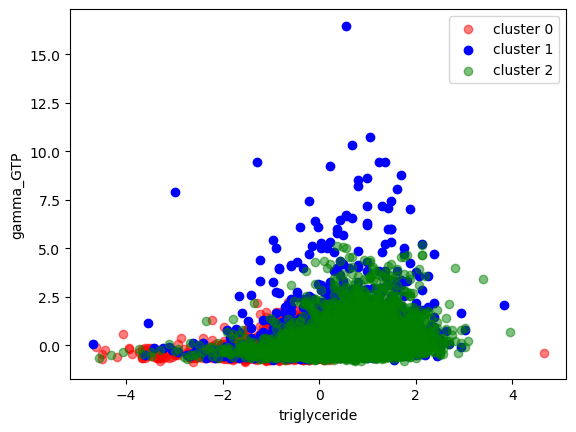

In [141]:
#scatter plot of triglyceride and gamma_GTP with cluster
plt.scatter(X_train[gmmCluster == 0,16],X_train[gmmCluster == 0,20],c='red',label='cluster 0',alpha=0.5)
plt.scatter(X_train[gmmCluster == 1,16],X_train[gmmCluster == 1,20],c='blue',label='cluster 1')
plt.scatter(X_train[gmmCluster == 2,16],X_train[gmmCluster == 2,20],c='green',label='cluster 2',alpha=0.5)
#add legend
plt.xlabel('triglyceride')
plt.ylabel('gamma_GTP')
plt.legend()
plt.show()

While we have a better score with 3 clusters, it doesnt seem to add much information : hypothesis much noise, in features, there should be better results zfter dimensionality reductions.

## Kmeans

In [150]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

sil_list_km = []

for i in range(2,23):
    
    kmeans = KMeans(n_clusters=i,random_state=random_state)
    kmeans.fit(X_train)
    sil_list_km.append(silhouette_score(X_train,kmeans.predict(X_train)))

/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: 

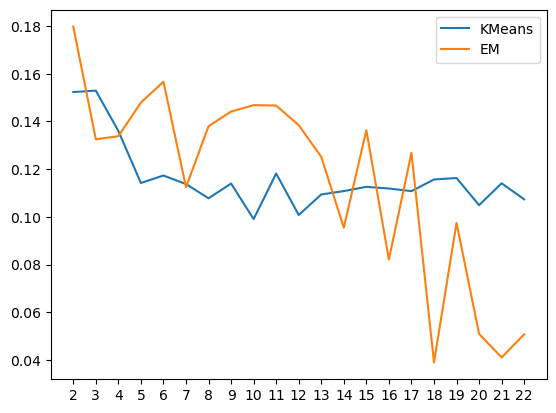

In [152]:
plt.plot(range(2,23),sil_list_km,label = 'KMeans')
plt.plot(range(2,23),sil_list,label = 'EM')
plt.xticks(range(2,23))
plt.legend()
plt.show()

In [379]:
km = KMeans(n_clusters=3,random_state=random_state)
km.fit(X_train)

/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=3, random_state=75)

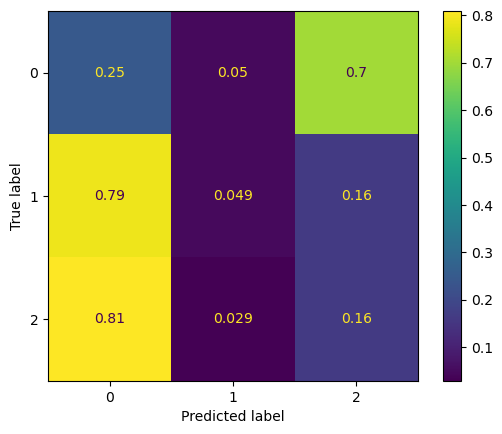

In [380]:
from sklearn.metrics import confusion_matrix

from sklearn.metrics import ConfusionMatrixDisplay
cm = confusion_matrix(y_train - 1,km.predict(X_train),normalize='true')
disp_km_lab = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['0','1','2'])

disp_km_lab.plot()


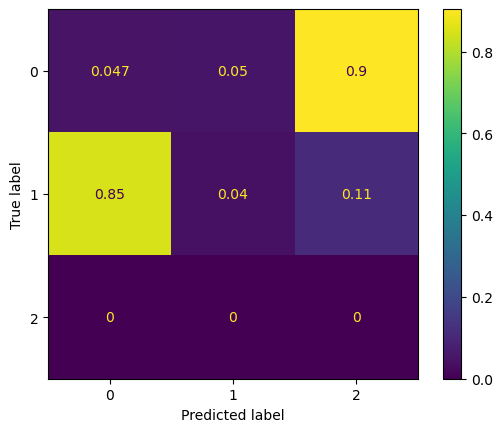

In [381]:
from sklearn.metrics import confusion_matrix

from sklearn.metrics import ConfusionMatrixDisplay
cm = confusion_matrix(X_train[:,0] > 0,km.predict(X_train),normalize='true')
disp_km_sex = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['0','1','2'])

disp_km_sex.plot()

[Text(0, 0, 'Cluster 0'), Text(1, 0, 'Cluster 1'), Text(2, 0, 'Cluster 2')]

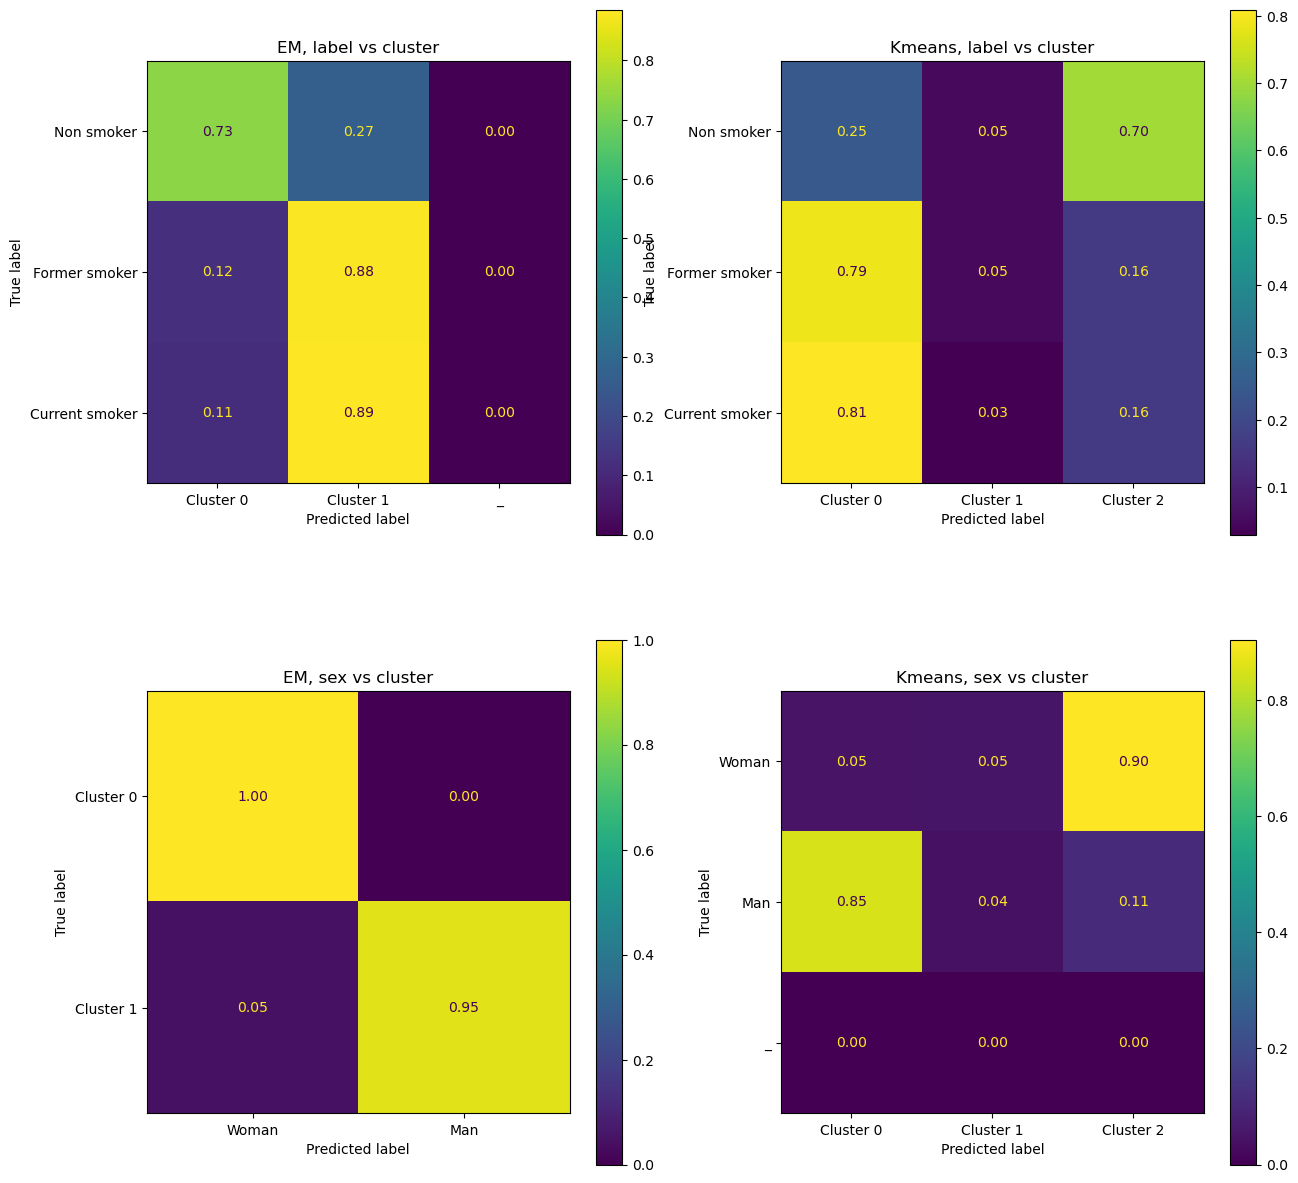

In [392]:
fig,ax = plt.subplots(2,2,figsize=(15,15))

ax[0,0] = disp_gmm_lab.plot(ax=ax[0,0],values_format='.2f')
ax[0,0].ax_.set_title('EM, label vs cluster')
ax[0,0].ax_.set_xticklabels(['Cluster 0','Cluster 1', '_'])
ax[0,0].ax_.set_yticklabels(['Non smoker','Former smoker', 'Current smoker'])


ax[0,1] = disp_km_lab.plot(ax=ax[0,1],values_format='.2f')
ax[0,1].ax_.set_title('Kmeans, label vs cluster')
ax[0,1].ax_.set_xticklabels(['Cluster 0','Cluster 1', 'Cluster 2'])
ax[0,1].ax_.set_yticklabels(['Non smoker','Former smoker', 'Current smoker'])



ax[1,0] = disp_gmm_sex.plot(ax=ax[1,0],values_format='.2f')
ax[1,0].ax_.set_title('EM, sex vs cluster')
ax[1,0].ax_.set_xticklabels(['Woman','Man'])
ax[1,0].ax_.set_yticklabels(['Cluster 0','Cluster 1'])


ax[1,1] = disp_km_sex.plot(ax=ax[1,1],values_format='.2f')
ax[1,1].ax_.set_title('Kmeans, sex vs cluster')
ax[1,1].ax_.set_yticklabels(['Woman','Man','_'])
ax[1,1].ax_.set_xticklabels(['Cluster 0','Cluster 1','Cluster 2'])


Same conclusion ; check gender disparity in cluster.

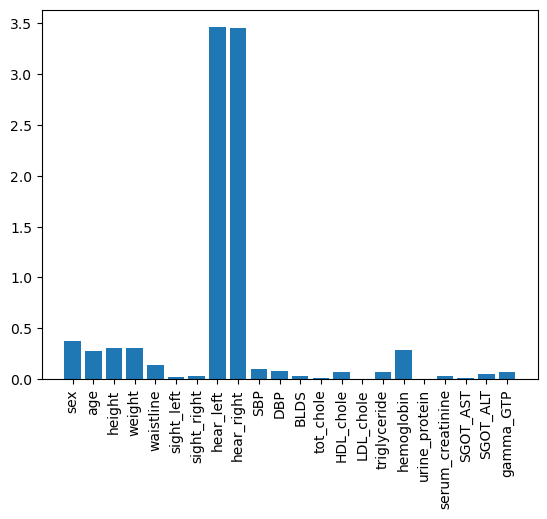

In [174]:
inter_cluster_variance = np.var(km.cluster_centers_,axis=0)
plt.bar(range(22),inter_cluster_variance)
plt.xticks(range(22),df.columns[:-1],rotation=90)
plt.show()

In [215]:
km.cluster_centers_[:,7:9] * dfStd[7:9].values + dfMean[7:9].values

array([[1.        , 1.000271  ],
       [1.68945312, 1.67773437],
       [1.00024343, 1.        ]])

In [214]:
dfStd[7:9] + dfMean[7:9]

hear_left     1.206145
hear_right    1.202368
dtype: float64

In [194]:
df.hear_left.describe()

count    9.913460e+05
mean    -3.164682e-16
std      1.000000e+00
min     -1.803294e-01
25%     -1.803294e-01
50%     -1.803294e-01
75%     -1.803294e-01
max      5.545403e+00
Name: hear_left, dtype: float64

In [182]:
np.cov(X_train[:,indcol1],X_train[:,indcol2])

array([[0.82628568, 0.58937044],
       [0.58937044, 0.89733596]])

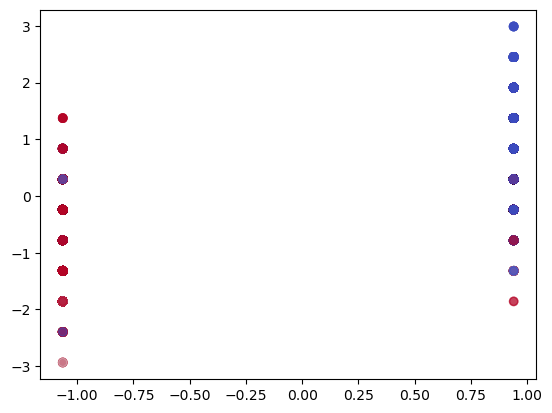

In [181]:
#scatter plot
col1 = 'sex'
col2 = 'height'

indcol1 = df.columns.get_loc(col1)
indcol2 = df.columns.get_loc(col2)

plt.scatter(X_train[:,indcol1],X_train[:,indcol2],c=km.predict(X_train),cmap='coolwarm',alpha=0.5)

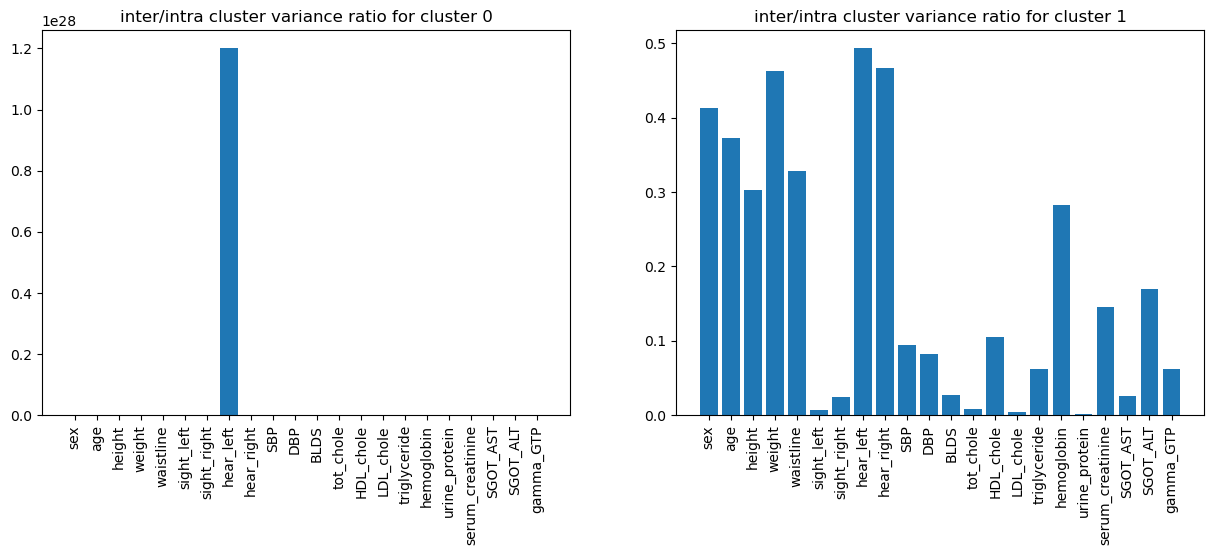

In [185]:
#get intra cluster variance for each features
intra_cluster_variance = []
for i in range(3):
    intra_cluster_variance.append(np.var(X_train[km.predict(X_train) == i],axis=0))
    
#get inter cluster variance for each features
inter_cluster_variance = np.var(km.cluster_centers_,axis=0)

#compute the ratio
ratio = inter_cluster_variance/intra_cluster_variance
fig, ax = plt.subplots(1,2,figsize=(15,5))
ax[0].bar(range(22),ratio[0],label='cluster 0')
ax[1].bar(range(22),ratio[1],label='cluster 1')
ax[0].set_xticks(range(22),df.columns[:-1],rotation=90)
ax[1].set_xticks(range(22),df.columns[:-1],rotation=90)
ax[0].set_title('inter/intra cluster variance ratio for cluster 0')
ax[1].set_title('inter/intra cluster variance ratio for cluster 1')

plt.show()

## PCA

In [243]:
from sklearn.decomposition import PCA
pca = PCA(random_state=random_state)
pca.fit(X_train)

PCA(random_state=75)

In [84]:
pca.explained_variance_ratio_

array([0.18556602, 0.11583545, 0.10160002, 0.07481904, 0.0640768 ,
       0.05844937, 0.05446761, 0.05091647, 0.04284053, 0.04028026,
       0.03515855, 0.03397717, 0.02888947, 0.02394601, 0.02191915,
       0.0203934 , 0.01450447, 0.01138031, 0.00830549, 0.00696623,
       0.00373234, 0.00197584])

In [244]:
for i in range(1,22):
    print('PCA',i,'components:',np.sum(pca.explained_variance_ratio_[:i]))

PCA 1 components: 0.18556601679033657
PCA 2 components: 0.3014014678956224
PCA 3 components: 0.40300149217945164
PCA 4 components: 0.477820527737178
PCA 5 components: 0.541897329901857
PCA 6 components: 0.6003467039240921
PCA 7 components: 0.6548143094856582
PCA 8 components: 0.70573078157834
PCA 9 components: 0.7485713099956824
PCA 10 components: 0.7888515671627083
PCA 11 components: 0.8240101154695285
PCA 12 components: 0.8579872841228473
PCA 13 components: 0.8868767576665036
PCA 14 components: 0.9108227674577953
PCA 15 components: 0.9327419211443572
PCA 16 components: 0.953135319476049
PCA 17 components: 0.9676397856156436
PCA 18 components: 0.9790201000645626
PCA 19 components: 0.9873255931648549
PCA 20 components: 0.9942918235783352
PCA 21 components: 0.9980241621435006


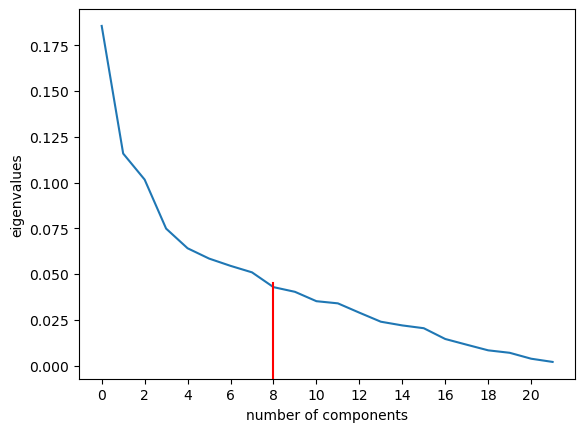

In [249]:
plt.plot(pca.explained_variance_ratio_)
plt.ylabel('eigenvalues')
plt.xticks(range(0,22,2))
plt.xlabel('number of components')
plt.axvline(8,color='red',ymax=0.26)

In [345]:
#Variance inflation factor for X_train
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = []
for i in range(X_train.shape[1]):
    vif.append(variance_inflation_factor(X_train,i))
for _,i in enumerate(vif):
    print(df.columns[_],':',i)

sex : 3.425415086924976
age : 1.8032461626760627
height : 3.6934737175608396
weight : 6.459477380825645
waistline : 4.43667415280408
sight_left : 1.0818911581973059
sight_right : 1.0949735276982164
hear_left : 1.3979301038771044
hear_right : 1.3945650425298088
SBP : 2.4407751241622107
DBP : 2.353500199885014
BLDS : 1.1378323927564038
tot_chole : 14.387116869566553
HDL_chole : 2.7795234094689727
LDL_chole : 12.475586310593002
triglyceride : 3.524522465001334
hemoglobin : 2.0633529104858845
urine_protein : 1.0369367231749076
serum_creatinine : 1.2054999828519497
SGOT_AST : 2.427344283757729
SGOT_ALT : 2.722530647836986
gamma_GTP : 1.4368462431461786


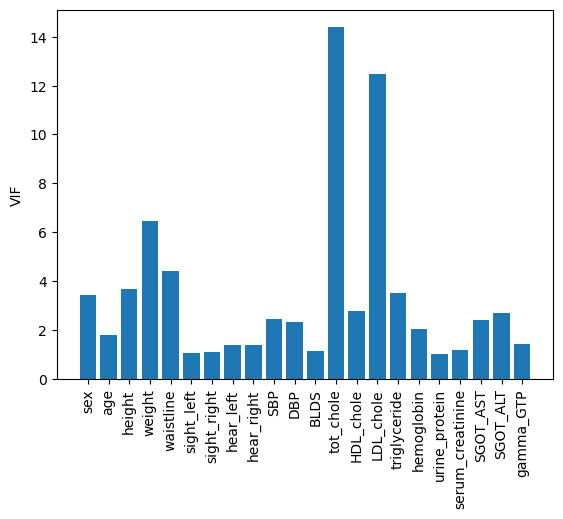

In [393]:
#barplot of the variance inflation factor
plt.bar(range(22),vif)
plt.xticks(range(22),df.columns[:-1],rotation=90)
plt.ylabel('VIF')
plt.show()

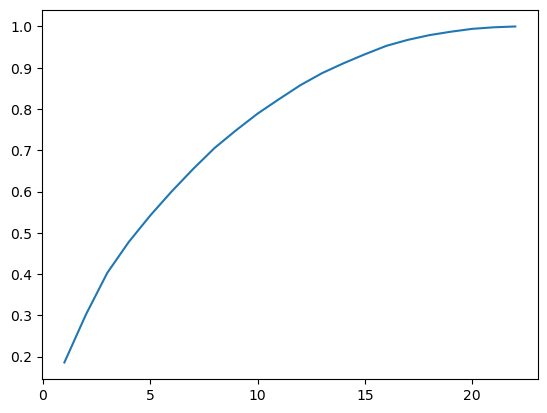

In [251]:
#Plot corresponding graph
plt.plot(range(1,23),np.cumsum(pca.explained_variance_ratio_))

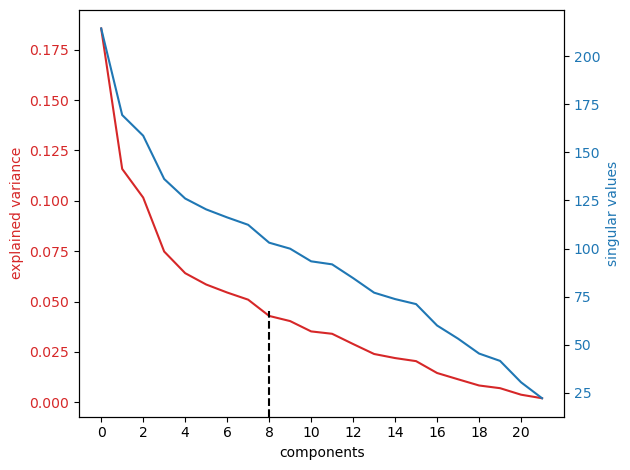

In [234]:
# Create some mock data

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('components')
ax1.set_ylabel('explained variance', color=color)
ax1.plot(pca.explained_variance_ratio_, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('singular values', color=color)  # we already handled the x-label with ax1
ax2.plot(pca.singular_values_, color=color)
ax2.tick_params(axis='y', labelcolor=color)
#vertical bar at x = 8 dotted
ax2.axvline(x=8,linestyle='--',color='black',ymax = 0.26)
#add xticks at 8
ax2.set_xticks(range(0,22,2))
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [235]:
n_featPCA = 8
pca = PCA(n_components=n_featPCA,random_state=random_state)
pca.fit(X_train)
X_train_PCA = pca.transform(X_train)
X_test_PCA = pca.transform(X_test)

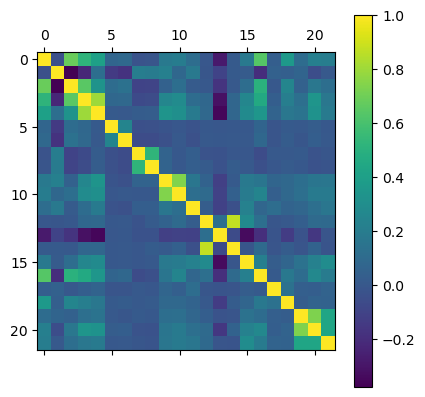

In [240]:
df_pca_train = pd.DataFrame(X_train)
plt.matshow(df_pca_train.corr())
plt.colorbar()
plt.show()

Select only features that add a marginal values less than a thresholds to the model?

## ICA

In [10]:
from sklearn.decomposition import FastICA

ica = FastICA(random_state=random_state)
ica.fit(X_train)


FastICA(random_state=75)

Text(0.5, 0, 'components')

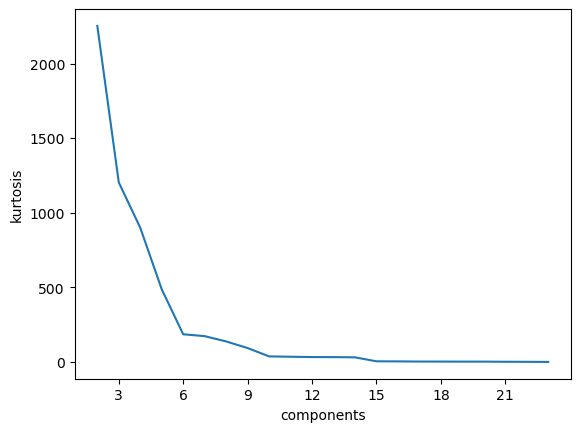

In [254]:
from scipy.stats import kurtosis
kurtosis(ica.transform(X_train))

#Plot the kurtosis of features in descending order
plt.plot(range(2,24),sorted(kurtosis(ica.transform(X_train),axis=0),reverse=True))
plt.xticks(range(3,24,3))
plt.ylabel('kurtosis')
plt.xlabel('components')

In [12]:
n_feat = 6
#Select the n_feat best features (best kurtosis)

ind_feat = np.argsort(kurtosis(ica.transform(X_train),axis=0))[::-1][:n_feat]

In [13]:
ica.transform(X_train)[:,ind_feat].shape

(12000, 6)

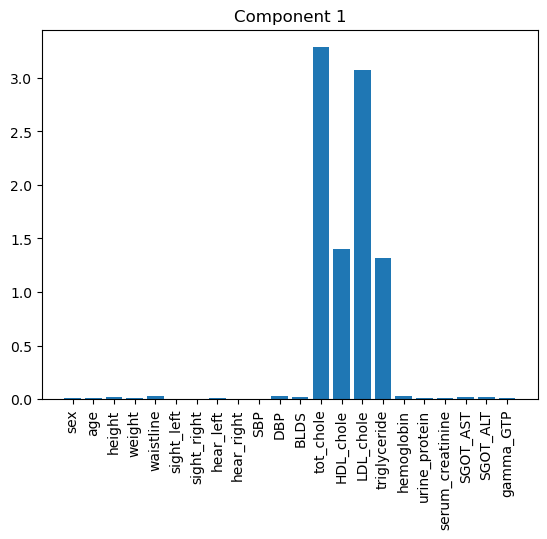

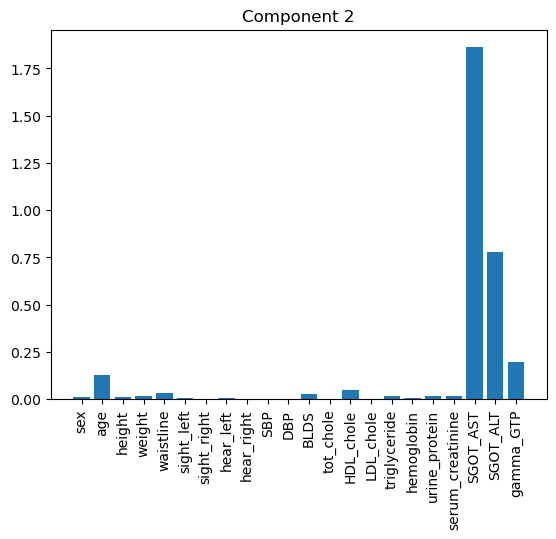

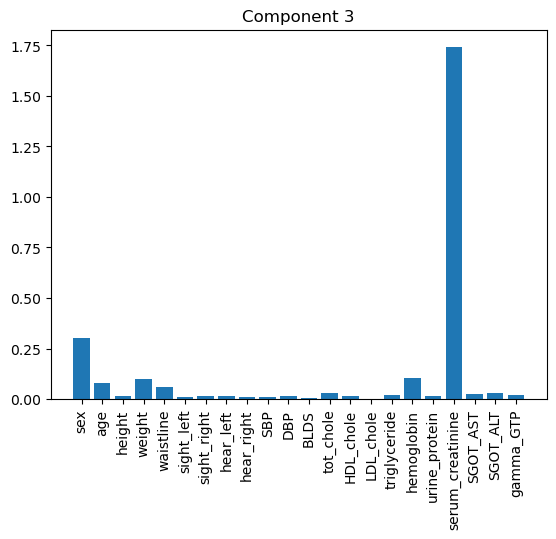

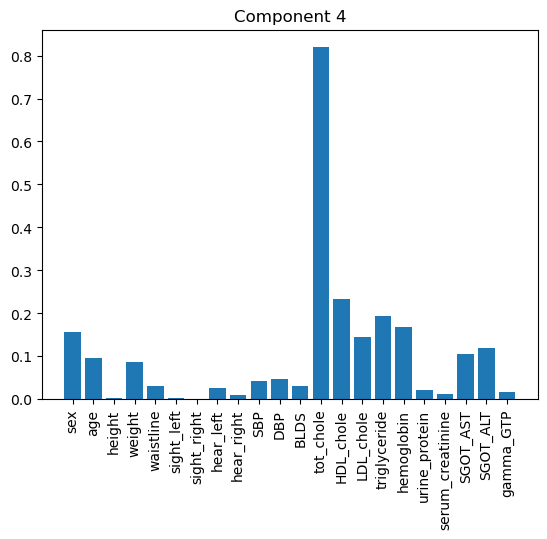

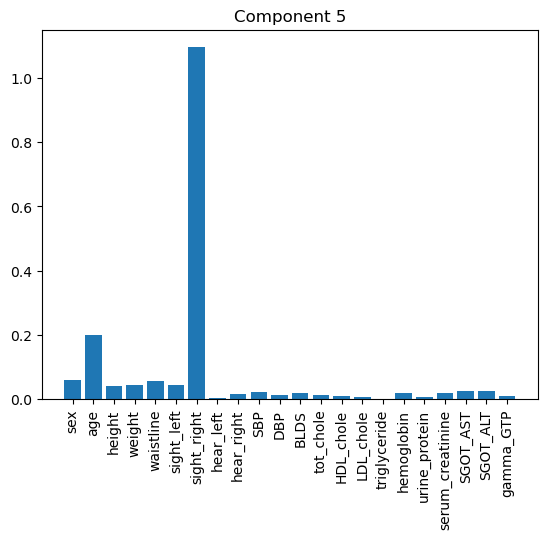

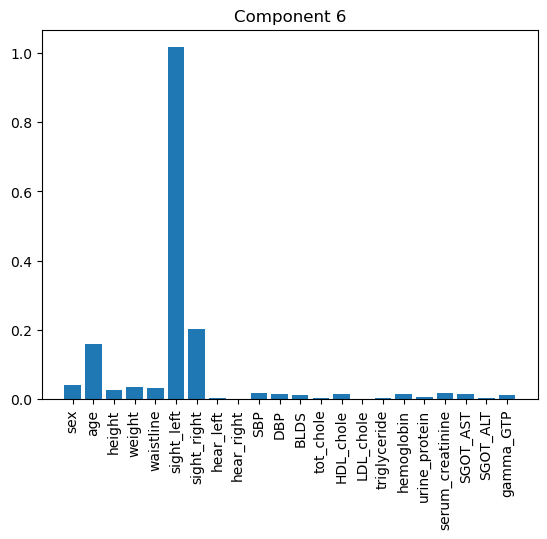

In [260]:
#for each component, plot the histogram of the corresponding feature
for _,i in enumerate(ind_feat):
    plt.bar(range(22),np.abs(ica.components_[i,:]))
    plt.title('Component '+str(_+1))
    plt.xticks(range(22),df.columns[:-1],rotation=90)
    plt.show()



In [252]:
ica.components_.shape

(22, 22)

In [287]:
X_train_ica = ica.transform(X_train)[:,ind_feat]
X_test_ica = ica.transform(X_test)[:,ind_feat]



In [342]:
#Variance inflation factor for X_train
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = []
for i in range(X_train_PCA.shape[1]):
    vif.append(variance_inflation_factor(X_train_PCA,i))
for _,i in enumerate(vif):
    print(i)

0.9999999999999993
1.0000000000000009
1.0000000000000002
0.9999999999999976
1.0000000000000002
0.9999999999999987
1.0000000000000027
1.0000000000000073


In [341]:
#Variance inflation factor for X_train
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = []
for i in range(X_train_ica.shape[1]):
    vif.append(variance_inflation_factor(X_train_ica,i))
for _,i in enumerate(vif):
    print(i)

1.0
0.9999999999999998
1.0000000000000002
0.9999999999999993
1.0
1.0000000000000002


In [53]:
df.columns

Index(['sex', 'age', 'height', 'weight', 'waistline', 'sight_left',
       'sight_right', 'hear_left', 'hear_right', 'SBP', 'DBP', 'BLDS',
       'tot_chole', 'HDL_chole', 'LDL_chole', 'triglyceride', 'hemoglobin',
       'urine_protein', 'serum_creatinine', 'SGOT_AST', 'SGOT_ALT',
       'gamma_GTP', 'SMK_stat_type_cd'],
      dtype='object')

## Randomized Projections

In [36]:
from sklearn.random_projection import GaussianRandomProjection
rp_error = []
for c in range(2,23):
    grp = GaussianRandomProjection(random_state=random_state,n_components=c)
    grp.fit(X_train)
    #print(np.linalg.norm(grp.inverse_transform(grp.transform(X_train)) - X_train))
    rp_error.append(np.linalg.norm(grp.inverse_transform(grp.transform(X_train)) - X_train))


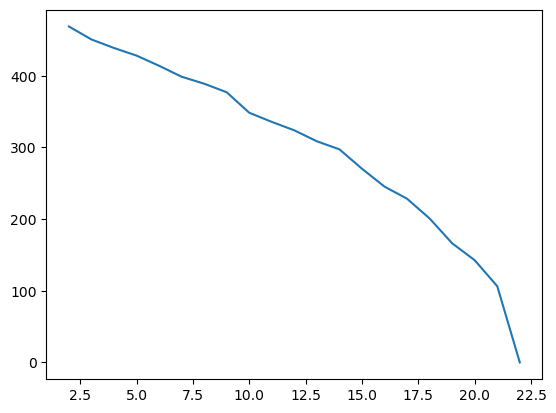

In [37]:
plt.plot(range(2,23),rp_error)

In [ ]:
np.linalg.norm(((grp.transform(X_train)) @ np.linalg.pinv(grp.components_ @ grp.components_.T) @ grp.components_) - X_train)

413.8224317046223

In [ ]:
grp.transform(X_train).shape

(12000, 6)

In [ ]:
from sklearn.random_projection import GaussianRandomProjection
proj_errors = []
for seeds in 10*np.arange(1,3):
    proj_error = []
    for comp in range(2,23):
        grp = GaussianRandomProjection(n_components=comp,random_state=seeds)
        grp.fit(X_train)

        X_train_grp = grp.transform(X_train)
        X_test_grp = grp.transform(X_test)

        #Reconstruction error
        from sklearn.metrics import mean_squared_error
        proj_error.append(mean_squared_error(X_train,grp.inverse_transform(X_train_grp)))
        
    proj_errors.append(proj_error)
    

## Isomap

In [16]:
from sklearn.manifold import Isomap
rc_iso = []
for c in range(2,23):
    print(c)
    iso = Isomap(n_components=c)
    iso.fit(X_train)
    rc_iso.append(iso.reconstruction_error())

2


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_isomap.py:359: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


3


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_isomap.py:359: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


4


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_isomap.py:359: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


5


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_isomap.py:359: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


6


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_isomap.py:359: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


7


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_isomap.py:359: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


8


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_isomap.py:359: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


9


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_isomap.py:359: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


10


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_isomap.py:359: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


11


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_isomap.py:359: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


12


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_isomap.py:359: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


13


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_isomap.py:359: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


14


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_isomap.py:359: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


15


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_isomap.py:359: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


16


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_isomap.py:359: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


17


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_isomap.py:359: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


18


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_isomap.py:359: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


19


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_isomap.py:359: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


20


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_isomap.py:359: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


21


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_isomap.py:359: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


22


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_isomap.py:359: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


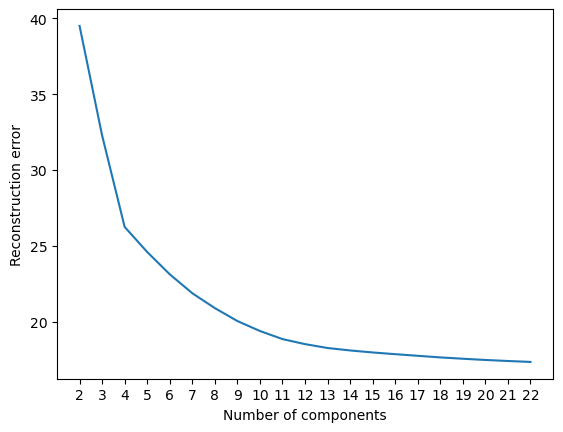

In [18]:
plt.plot(range(2,23),rc_iso)
plt.xticks(range(2,23))
plt.xlabel('Number of components')
plt.ylabel('Reconstruction error')
plt.show()

In [39]:
n_comp_iso = 11

iso = Isomap(n_components=n_comp_iso)

iso.fit(X_train)

X_train_iso = iso.transform(X_train)
X_test_iso = iso.transform(X_test)

/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_isomap.py:359: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


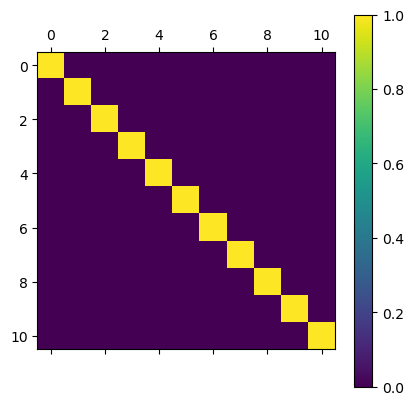

In [270]:
df_icca_train = pd.DataFrame(X_train_iso)
plt.matshow(df_icca_train.corr())
plt.colorbar()
plt.show()

In [273]:
np.corrcoef(X_train_iso)

array([[ 1.        , -0.2577866 , -0.018476  , ..., -0.01287142,
        -0.12470569, -0.11070583],
       [-0.2577866 ,  1.        ,  0.73127786, ..., -0.68295722,
        -0.55515269, -0.43554894],
       [-0.018476  ,  0.73127786,  1.        , ..., -0.59400574,
        -0.54636136, -0.63125335],
       ...,
       [-0.01287142, -0.68295722, -0.59400574, ...,  1.        ,
         0.58937863,  0.81763392],
       [-0.12470569, -0.55515269, -0.54636136, ...,  0.58937863,
         1.        ,  0.25557895],
       [-0.11070583, -0.43554894, -0.63125335, ...,  0.81763392,
         0.25557895,  1.        ]])

In [343]:
#Variance inflation factor for X_train
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = []
for i in range(X_train_iso.shape[1]):
    vif.append(variance_inflation_factor(X_train_iso,i))
for _,i in enumerate(vif):
    print(i)

1.0000000000000004
1.0000000000000075
1.0000000000000002
1.0000000000000016
1.0000000000000049
1.0000000000000053
0.9999999999999978
1.000000000000002
0.9999999999999971
0.9999999999999978
1.0000000000000004


## PART 3 :

In [399]:
from sklearn.metrics import silhouette_score
sil_list_em_ica = []
for i in range(2,12):
    gmm = GaussianMixture(n_components=i,random_state=random_state)
    gmm.fit(X_train_ica)
    sil_list_em_ica.append(silhouette_score(X_train_ica,gmm.predict(X_train_ica)))

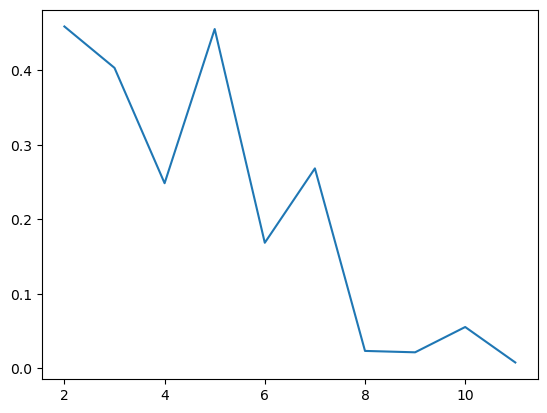

In [400]:
plt.plot(range(2,12),sil_list_em_ica)

In [288]:
from sklearn.metrics import confusion_matrix
gmm = GaussianMixture(n_components=5,random_state=random_state)
gmm.fit(X_train_ica)

GaussianMixture(n_components=5, random_state=75)

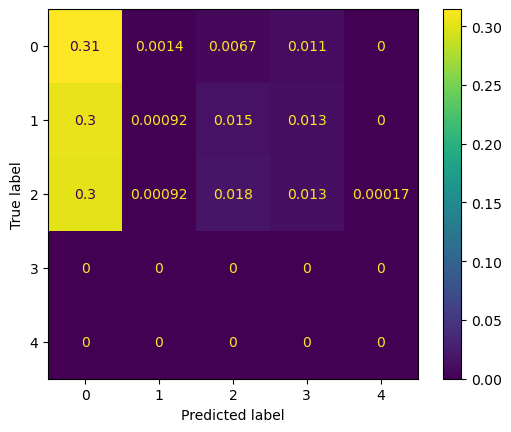

In [289]:
from sklearn.metrics import confusion_matrix

from sklearn.metrics import ConfusionMatrixDisplay
cm = confusion_matrix(y_train - 1,gmm.predict(X_train_ica),normalize='all')
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=[str(i) for i in range(5)])

disp.plot()

In [291]:
inter_cluster_variance3em = np.var(gmm.means_,axis=0)

In [292]:
inter_cluster_variance3em

array([4.46298060e-01, 3.35058574e+02, 1.58050448e-01, 7.90366485e-01,
       2.29388042e+01, 7.46325137e-01])

kmean for ICA

In [397]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

sil_list_kmean_ica = []

for i in range(2,12):
    
    kmeans = KMeans(n_clusters=i,random_state=random_state)
    kmeans.fit(X_train_ica)
    sil_list_kmean_ica.append(silhouette_score(X_train_ica,kmeans.predict(X_train_ica)))

/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: 

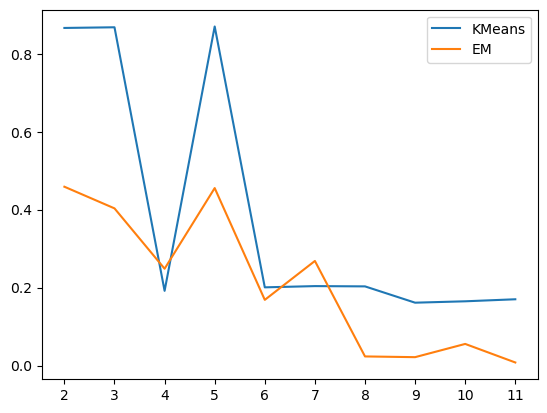

In [402]:
plt.plot(range(2,12),sil_list_kmean_ica,label = 'KMeans')
plt.plot(range(2,12),sil_list_em_ica,label = 'EM')
plt.xticks(range(2,12))
plt.legend()
plt.show()

In [299]:
np.argmax(sil_list_kmean_ica)

3

/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


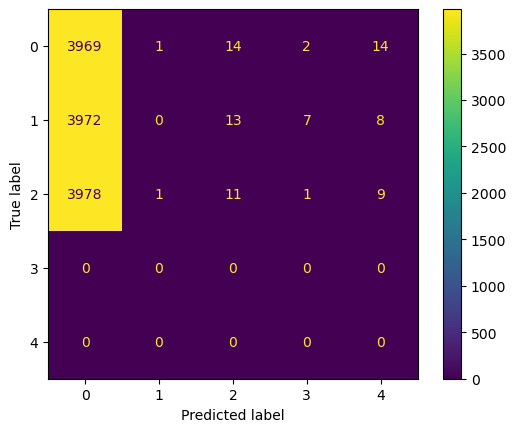

In [405]:
km_ica = KMeans(n_clusters=5,random_state=random_state)
km_ica.fit(X_train_ica)

from sklearn.metrics import confusion_matrix

from sklearn.metrics import ConfusionMatrixDisplay
cm = confusion_matrix(y_train - 1,km_ica.predict(X_train_ica))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=[str(i) for i in range(5)])

disp.plot()

REGARDER Répartition par genre??????

iso

In [61]:
from sklearn.metrics import silhouette_score
sil_list_em_iso = []
for i in range(2,11):
    gmm = GaussianMixture(n_components=i,random_state=random_state)
    gmm.fit(X_train_iso)
    sil_list_em_iso.append(silhouette_score(X_train_iso,gmm.predict(X_train_iso)))

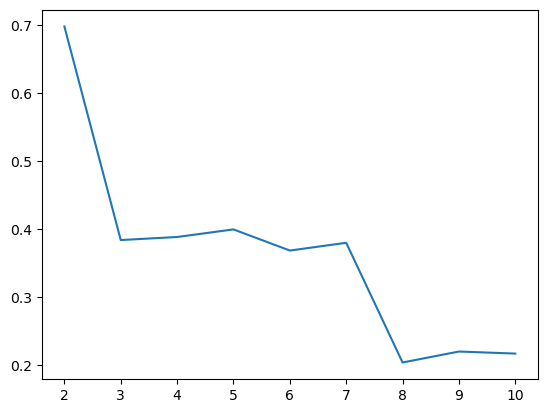

In [62]:
plt.plot(range(2,11),sil_list_em_iso)

In [354]:
from sklearn.metrics import confusion_matrix
gmm = GaussianMixture(n_components=4,random_state=random_state)
gmm.fit(X_train_iso)

GaussianMixture(n_components=4, random_state=75)

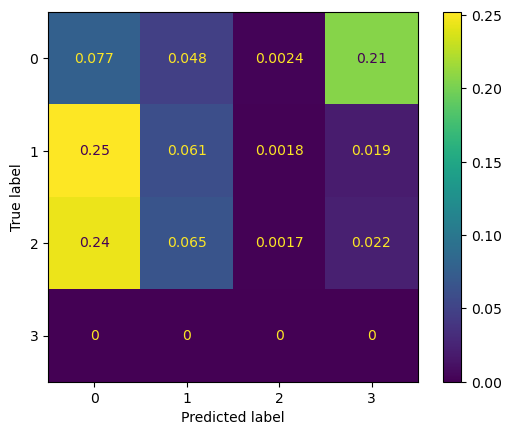

In [370]:
from sklearn.metrics import confusion_matrix

from sklearn.metrics import ConfusionMatrixDisplay
cm = confusion_matrix(y_train - 1,gmm.predict(X_train_iso),normalize='all')
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=[str(i) for i in range(4)])

disp.plot()

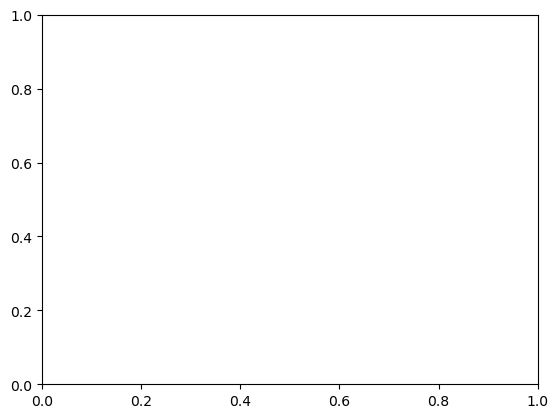

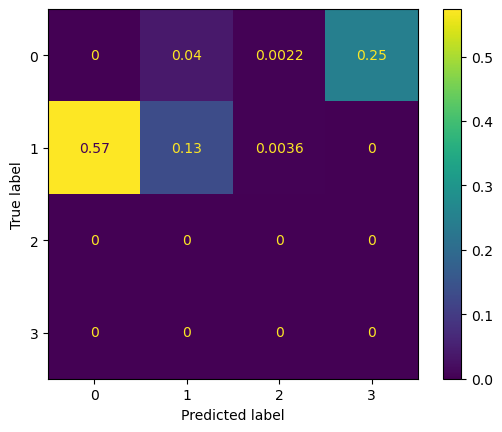

In [371]:
from sklearn.metrics import confusion_matrix

from sklearn.metrics import ConfusionMatrixDisplay
cm = confusion_matrix(X_train[:,0]>0,gmm.predict(X_train_iso),normalize='all')
fig, ax = plt.subplots()
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=[str(i) for i in range(4)])



disp.plot()

Pas de différenciation avec peu de lcusters, différentiation avec bcp de cluster

kmean iso :

In [76]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

sil_list_kmean_iso = []

for i in range(2,12):
    
    kmeans = KMeans(n_clusters=i,random_state=random_state)
    kmeans.fit(X_train_iso)
    sil_list_kmean_iso.append(silhouette_score(X_train_iso,kmeans.predict(X_train_iso)))

/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: 

Text(0, 0.5, 'Silhouette Score')

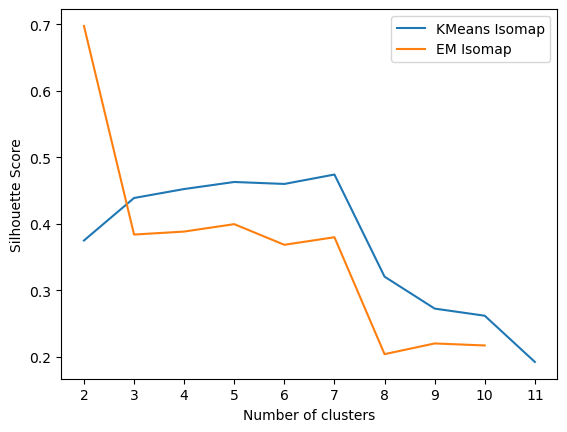

In [307]:
plt.plot(range(2,12),sil_list_kmean_iso,label='KMeans Isomap')

plt.plot(range(2,11),sil_list_em_iso,label='EM Isomap')
plt.xticks(range(2,12))
plt.legend()
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')

/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


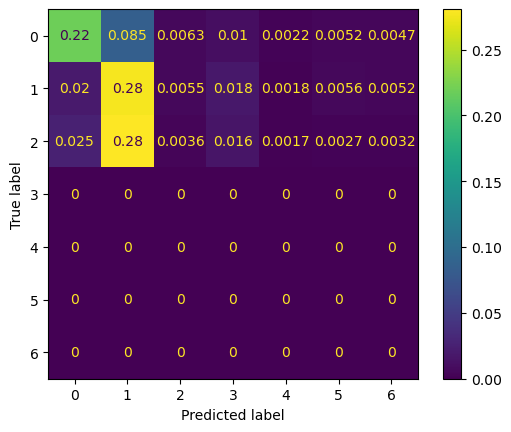

In [407]:
km_iso = KMeans(n_clusters=7,random_state=random_state)
km_iso.fit(X_train_iso)

from sklearn.metrics import confusion_matrix

from sklearn.metrics import ConfusionMatrixDisplay
cm_iso_km_lab = confusion_matrix(y_train - 1,km_iso.predict(X_train_iso),normalize='all')
disp_iso_km_lab = ConfusionMatrixDisplay(confusion_matrix=cm_iso_km_lab,display_labels=[str(i) for i in range(7)])

disp.plot()

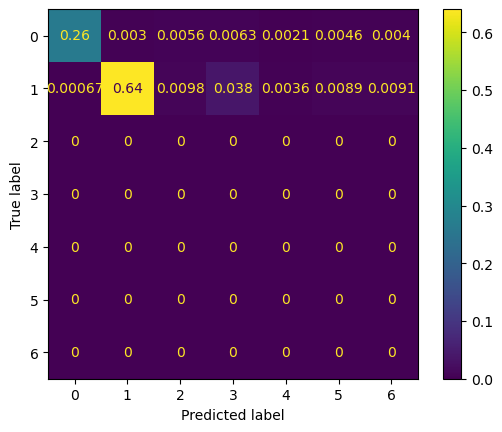

In [409]:
cm_iso_km_sex = confusion_matrix(X_train[:,0] > 0,km_iso.predict(X_train_iso),normalize='all')
disp_iso_km_sex = ConfusionMatrixDisplay(confusion_matrix=cm_iso_km_sex,display_labels=[str(i) for i in range(7)])
disp_iso_km_sex.plot()

[Text(0, 0, 'Female'),
 Text(0, 1, 'Male'),
 Text(0, 2, '_'),
 Text(0, 3, '_'),
 Text(0, 4, '_'),
 Text(0, 5, '_'),
 Text(0, 6, '_')]

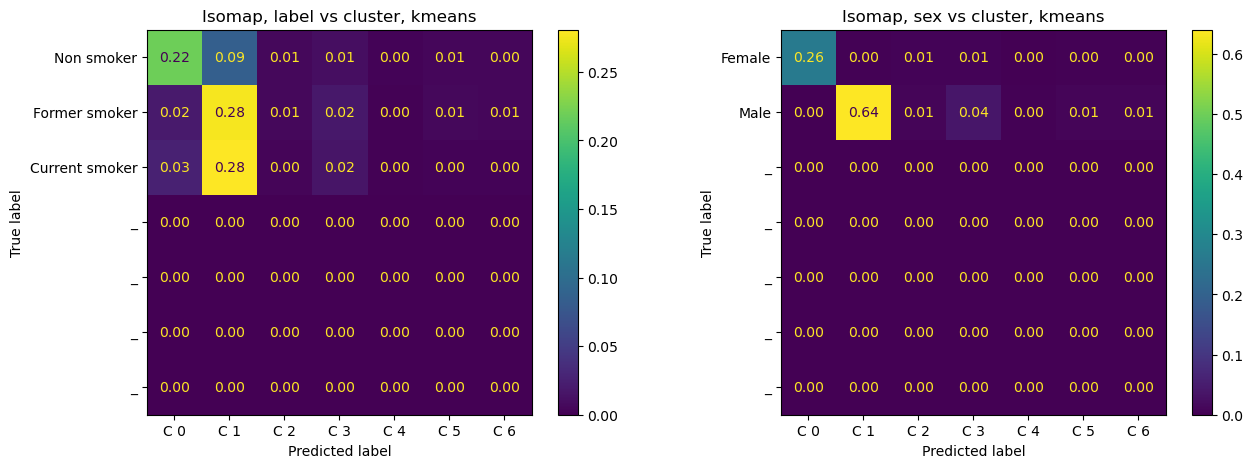

In [414]:
fig, ax = plt.subplots(1,2,figsize=(15,5))

ax[0] = disp_iso_km_lab.plot(ax=ax[0],values_format='.2f')
ax[0].ax_.set_title('Isomap, label vs cluster, kmeans')
ax[0].ax_.set_xticklabels(['C 0','C 1', 'C 2','C 3','C 4','C 5','C 6'])
ax[0].ax_.set_yticklabels(['Non smoker','Former smoker', 'Current smoker','_','_','_','_'])

ax[1] = disp_iso_km_sex.plot(ax=ax[1],values_format='.2f')
ax[1].ax_.set_title('Isomap, sex vs cluster, kmeans')

ax[1].ax_.set_xticklabels(['C 0','C 1', 'C 2','C 3','C 4','C 5','C 6'])
ax[1].ax_.set_yticklabels(['Female','Male', '_','_','_','_','_'])


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


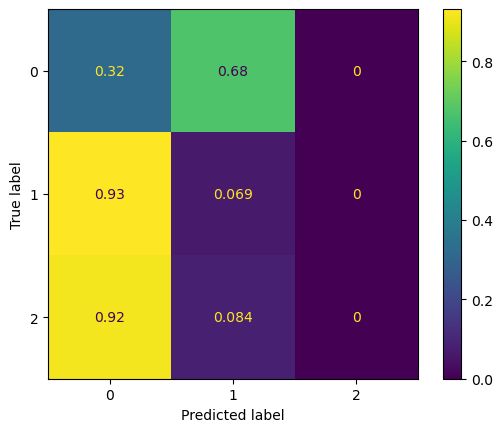

In [351]:
km_iso = KMeans(n_clusters=2,random_state=random_state)
km_iso.fit(X_train_iso)

from sklearn.metrics import confusion_matrix

from sklearn.metrics import ConfusionMatrixDisplay
cm = confusion_matrix(y_train - 1,km_iso.predict(X_train_iso),normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=[str(i) for i in range(3)])

disp.plot()